Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

/opt/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/opt/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Download the data from the source website if necessary.

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string.

In [7]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data type is {} of {}'.format(type(words),type(words[0])))
print('Data size %d' % len(words))


Data type is <class 'list'> of <class 'str'>
Data size 17005207


Build the dictionary and replace rare words with UNK token.

In [8]:
vocabulary_size = 50000

def build_dataset(words):

  #List of words, with their number of occurrence
  count = [['UNK', -1]]
  #Get number of hits in the text database for each of the 50k most used words, sorted by decreasing order
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))

  #word - index associative mapping
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
    
  #Original text expressed as a list of indexes from dictionary instead of list of actual words
  data = list()
    
  #Now, make the word-inde translation, Every unknown word is indexed as 0, (UNK)
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)

  #Update the number of hit for the unknown words
  count[0][1] = unk_count
    
  # also provide the inverse associative map: index - words as reverse_dictionary
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]


Function to generate a training batch for the skip-gram model.

In [9]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  """ Divide the dataset (list of indexes) into smaller batches of feature/label pair
  
  We recall that in the skip-gram model, we are interested in getting the probability for each word,
  to be in the vicinity of a reference word. Vicinity is defined as skip_window, a skip_window of 2 means
  that a word is considered in the vicinity of another if its index in the sentence is +/- 2 of the 
  reference word index.
  
  A feature consist in 1 word (as index in the dictionary), and a label consist in 1 word (also as index)
  in its vicinity
  
  Args:
    batch_size: number of sample/label pair in each batch
    num_skips: number of randomly selected pair (word-neighboring word) for each word in the text
    skip_window: defines the vicinity size
  """

  global data_index
  #A batch must consist in multiple num_skips word-neigbouring word pairs
  assert batch_size % num_skips == 0
  #num_skips cannort exceed the number of neighbouring words
  assert num_skips <= 2 * skip_window
  #a batch is simply a list of indices (refering to the dictionary) standing for the word under consideration
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  #for each element of the batch, there is a label (index of the neigbouring word in the dictionary)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  #span is the size of the window under consideration that contains word of interest, + previous winddows
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    
  # dequeu, pronounced "deck" allow fast push and pop to both end of the inner list
  #Here, we initialize the window with data from the text
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
    
  #We will iterate on each central word to fill the batch
  for i in range(batch_size // num_skips):
    # target label at the center of the buffer
    target = skip_window
    targets_to_avoid = [ skip_window ]
    
    #For each central word, we iterate on the num_skip neigbour to be added
    for j in range(num_skips):
      #that is kind of inefficient, but yeah...
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      #Add central word to batch
      batch[i * num_skips + j] = buffer[skip_window]
      #Add neighbouring word to labels
      labels[i * num_skips + j, 0] = buffer[target]
    #Now move window away by 1 element
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

#Print data sample
print('data:', [reverse_dictionary[di] for di in data[:8]])

#Print exaple of batch for 2 configurations of vicinity/text sampling
for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['as', 'anarchism', 'a', 'originated', 'term', 'as', 'of', 'a']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['a', 'anarchism', 'originated', 'term', 'of', 'as', 'originated', 'term']


Train a skip-gram model.

In [11]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector. (original paper uses 300)
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [12]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.948473
Nearest to it: zebra, huey, lyre, hyacinthus, consecutive, subsidised, misandry, fie,
Nearest to four: gerardus, freyja, sahib, irrespective, destabilize, caesars, adaptable, neuroimaging,
Nearest to often: earle, vented, watchtower, permanently, zoning, undead, enunciated, nicol,
Nearest to new: complicating, hypothesize, danny, oh, byzantine, fridays, mellows, sounded,
Nearest to so: contrapuntal, painterly, characterized, sprengel, tsuburaya, gdr, thetis, tripoli,
Nearest to state: falciparum, sox, watterson, irt, regency, perspectives, kazakh, gpmg,
Nearest to six: roberto, vital, cartan, zona, nitrite, romanticism, amputee, accountancy,
Nearest to not: misspelled, bail, ithaca, hplc, bipartisan, rss, leffler, pittsburgh,
Nearest to i: impassioned, vehicles, lieben, deceiving, coughlin, displayed, benetton, young,
Nearest to an: novi, wy, osborne, cycladic, shotgun, custis, toni, quantification,
Nearest to all: salts, ecoregion, impressi

Average loss at step 52000: 3.439915
Average loss at step 54000: 3.432060
Average loss at step 56000: 3.439328
Average loss at step 58000: 3.397955
Average loss at step 60000: 3.391559
Nearest to it: he, there, she, this, they, toaster, what, we,
Nearest to four: five, six, eight, three, seven, nine, two, zero,
Nearest to often: usually, sometimes, commonly, generally, frequently, also, now, still,
Nearest to new: hotly, member, seljuk, genetic, billie, devlin, heathland, toland,
Nearest to so: packing, thus, then, benevolent, if, malting, understandably, oxidise,
Nearest to state: causative, government, counties, states, compactly, sesame, kind, baresi,
Nearest to six: eight, four, five, seven, nine, three, zero, two,
Nearest to not: usually, still, never, grassy, now, they, almost, therefore,
Nearest to i: ii, we, you, t, they, fema, bettors, sparkle,
Nearest to an: oncology, novi, wy, nam, missal, fw, totleben, osborne,
Nearest to all: some, both, these, many, those, every, various,

In [13]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

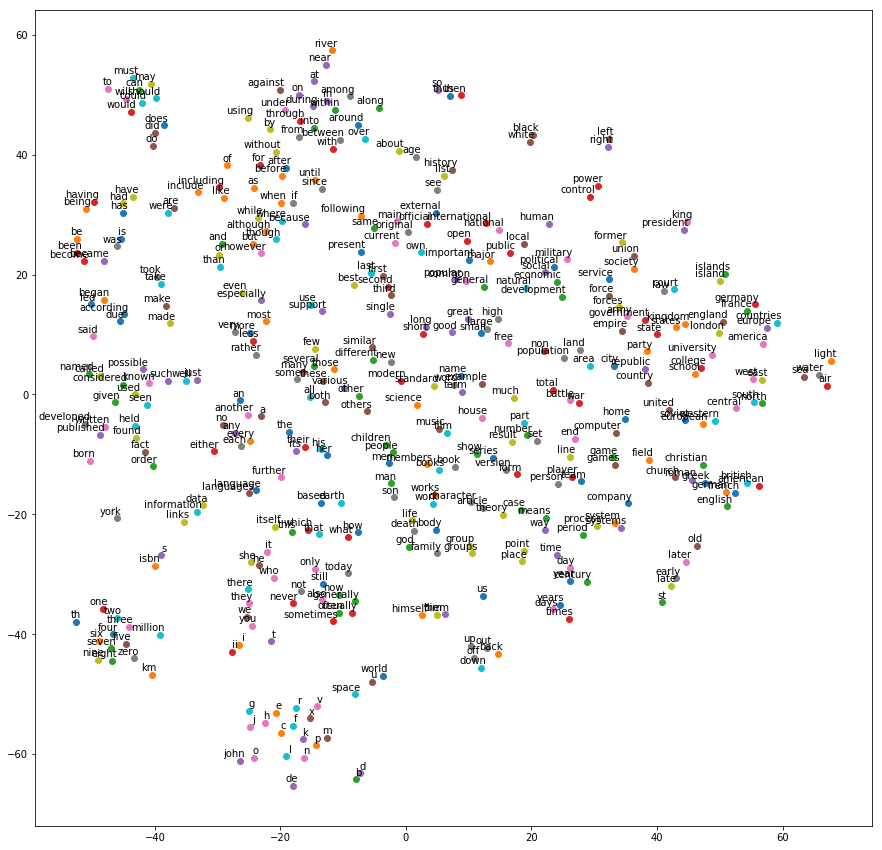

In [14]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

In [25]:
import itertools
data_index = 0

def generate_batch2(batch_size, window):
  """ Divide the dataset (list of indexes) into smaller batches of feature/label pair
  
  We recall that in the CBOW model, we are interested in predicting the central word, given a context of 
  surrounding words.
  Vicinity is defined as window, a window of 2 means that a word is considered in the vicinity of another if its
  index in the sentence is +/- 2 of the reference word index.
  
  A feature consist in 2*windows words (as index in the dictionary), and a label consist in 1 word (also as index)
  in the middle
  
  Args:
    batch_size: number of sample/label pair in each batch
    window: defines the vicinity size
  """

  global data_index
  #a batch is simply a list of indices (refering to the dictionary) standing for the set of words
  #that makes the context under consideration
  batch = np.ndarray(shape=(batch_size,2*window), dtype=np.int32)
  #for each element of the batch, there is a label (index of the central word in the dictionary)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  #span is the size of the window under consideration that contains word of interest, + previous winddows
  span = 2 * window + 1 # [ window target window ]
    
  # dequeue, pronounced "deck" allow fast push and pop to both end of the inner list
  #Here, we initialize the window with data from the text
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)

  #We will iterate on each central word to fill the batches+labels
  for i in range(batch_size):    
    #For each central word, we add its surroundings
    batch[i,:window] = list(itertools.islice(buffer, 0, window))
    batch[i,window:] = list(itertools.islice(buffer, window+1, len(buffer)))

    #Add central word to labels
    labels[i, 0] = buffer[window]

    #Now move window away by 1 element
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  assert batch.shape[0]==batch_size and batch.shape[1]==span-1
  return batch, labels

#Print data sample
print('data:', [reverse_dictionary[di] for di in data[:8]])

#Print exaple of batch for 2 configurations of vicinity/text sampling
for window in [1, 2]:
    data_index = 0
    batch, labels = generate_batch2(batch_size=8, window=window)
    print('\nwith window = {}:'.format(window))
    for i in range(8):
      print('    batch:', [reverse_dictionary[bi] for bi in batch[i]])
      print('    label:', [reverse_dictionary[li] for li in labels[i]])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with window = 1:
    batch: ['anarchism', 'as']
    label: ['originated']
    batch: ['originated', 'a']
    label: ['as']
    batch: ['as', 'term']
    label: ['a']
    batch: ['a', 'of']
    label: ['term']
    batch: ['term', 'abuse']
    label: ['of']
    batch: ['of', 'first']
    label: ['abuse']
    batch: ['abuse', 'used']
    label: ['first']
    batch: ['first', 'against']
    label: ['used']

with window = 2:
    batch: ['anarchism', 'originated', 'a', 'term']
    label: ['as']
    batch: ['originated', 'as', 'term', 'of']
    label: ['a']
    batch: ['as', 'a', 'of', 'abuse']
    label: ['term']
    batch: ['a', 'term', 'abuse', 'first']
    label: ['of']
    batch: ['term', 'of', 'first', 'used']
    label: ['abuse']
    batch: ['of', 'abuse', 'used', 'against']
    label: ['first']
    batch: ['abuse', 'first', 'against', 'early']
    label: ['used']
    batch: ['first', 'used', 'early', 'workin

Now defining training of the CBOW model

In [40]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector. (original paper uses 300)
window = 1 # How many words to consider left and right.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size,2*window])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.reduce_mean(tf.nn.embedding_lookup(embeddings, train_dataset), axis=1)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights,
                               biases=softmax_biases, inputs=embed,
                               labels=train_labels,
                               num_sampled=num_sampled,
                               num_classes=vocabulary_size))    
  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [41]:
#%% Session
    
num_steps = 100001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    avg_loss = 0
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch2(batch_size, skip_window)
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict = feed_dict)
        avg_loss += l
        if step%2000==0 and step>0:
            avg_loss = avg_loss/2000
            print('Average loss at step %d: %f' % (step, avg_loss))
            avg_loss = 0
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()

Initialized
Nearest to see: cubical, neapolitan, referendum, bootstrapping, libro, capitalists, playboy, digimon,
Nearest to one: pulpit, colombo, wikimedia, amass, catalyzed, treason, amalgamated, airplane,
Nearest to while: abrogated, recoverable, impacting, branson, buckminster, bulbs, atlantean, khoi,
Nearest to UNK: dhcp, essentials, partially, hydrothermal, franc, bulletproof, personalized, chariot,
Nearest to that: kilmer, rst, tba, mercenary, carcinogenic, surveillance, swf, racially,
Nearest to from: prior, unicef, neutralize, sackville, violating, venatici, nouns, aversion,
Nearest to or: attained, initialized, pretended, oslo, erica, nominee, shebaa, prospered,
Nearest to over: endian, downloaded, swivel, xp, gec, rohypnol, canadians, reversals,
Nearest to used: mansur, tackle, macpherson, noses, bullets, crewmembers, hippopotamus, ayer,
Nearest to known: umbrella, kundalini, cask, mic, satirize, reconciling, mammoth, bundesrat,
Nearest to at: symbolically, samba, mira, ide,

Average loss at step 52000: 2.880483
Average loss at step 54000: 2.849208
Average loss at step 56000: 2.846106
Average loss at step 58000: 2.857828
Average loss at step 60000: 2.842128
Nearest to see: includes, include, curran, but, including, russ, chronological, acapulco,
Nearest to one: two, seven, five, four, six, three, navarrese, eight,
Nearest to while: although, when, after, however, though, una, bcl, prefers,
Nearest to UNK: lacquer, cfa, extensible, aga, albert, visitation, otter, arrests,
Nearest to that: which, what, however, this, toon, precision, carcinogenic, cigar,
Nearest to from: through, into, venatici, after, canonic, neutralize, crystalline, terra,
Nearest to or: and, than, stardust, mus, paddock, occuring, budgeted, ncia,
Nearest to over: through, customizable, confining, around, arianespace, about, cdp, climb,
Nearest to used: involved, known, given, referred, available, released, understood, responsible,
Nearest to known: used, defined, possible, ol, serve, refe

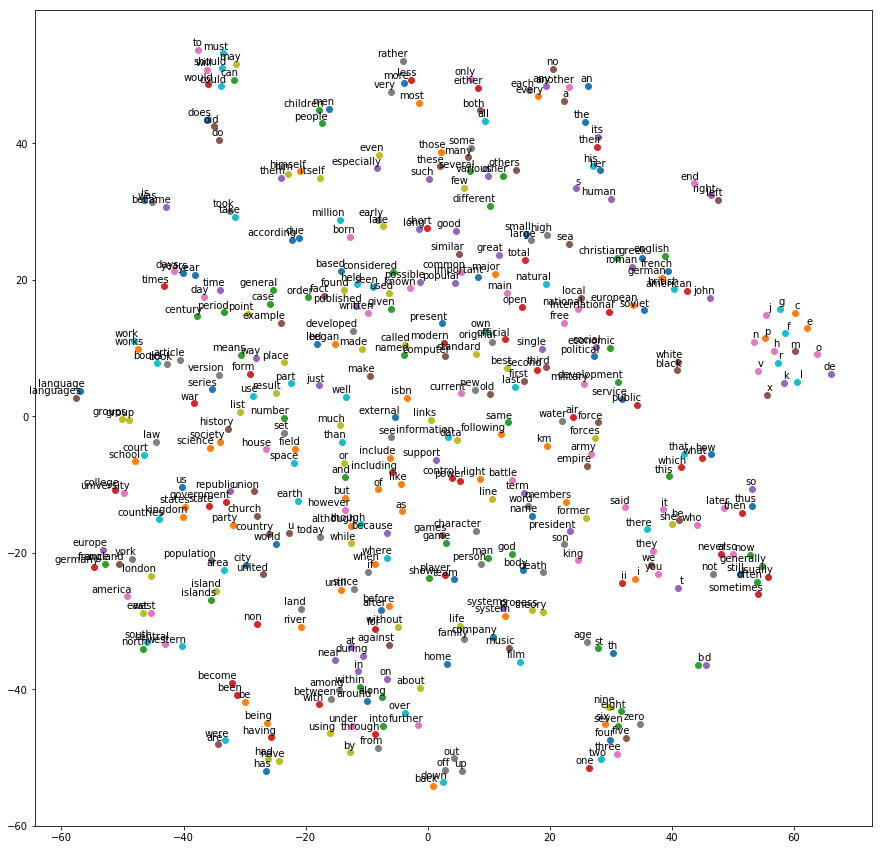

In [42]:
#%% Visualization using TSNE

num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)